# Relazione
In questo file vengono utilizzate classi e metodi del package `opandas_wb.api` per analizzare e costruire grafici dai dati presi da World Bank. Tutte le funzioni in questo modulo sono state pensate per essere utilizzate dall'utente finale del package `opandasWorldBank`, mentre gli altri package contengono funzioni di piu' basso livello, richiamate dai moduli in `opandas_wb.api`.

Nel sottopackage `sqlite` è presente una classe (CacheDB) che gestisce un database SQLite `cache.db` usato come cache dove vengono salvati i dati richiesti per la prima volta da world bank, così da evitare ulteriori chiamate alle API World Bank per le richieste successive e migliorare le prestazioni.

La prima volta che viene utilizzata una funzione che istanzia `CacheDB`, come quelle del modulo `fetch`, il database si crea *automaticamente* e crea anche tutte le tabelle, se ancora non sono state create. Infine, quando viene distrutta la istanza di CacheDB, viene anche chiusa la connessione al database. Tutte le istruzioni SQL sono nel file `constants.py` e definiscono le operazioni CRUD per topics, indicatori e osservabili, sfruttando le rispettive classi `Topic`, `Indicator` e `Observable` definite nel sottopackage `wb`.

Il database è costituito da quattro tabelle:
- Topics: id del topic, nome del topic e descrizione del topic
- Indicators: sigla dell’indicatore, nome esteso dell’indicatore, breve descrizione dell’indicatore
- Observables: sigla dell’indicatore di riferimento, paese di riferimento, anno dell’osservabile, valore dell’osservabile
- Tabella pivot per poter identificare tutti i topic relativi a un Indicator

Nel modulo `fetch.py` sono contenuti tutti i metodi che permettono di gestire il db ed in caso le query non vadano a buon fine scarica e salva tutti i dati ottenuti attraverso le API WorldBank. Tutte le funzioni del modulo `fetch` hanno un parametro booleano opzionale `force_update` che se posto a `True` scarica sempre da worldbank anche se i dati sono presenti nel database, permettendo all'utente di aggiornare osservabili, indicatori e topics.

Questi ultimi sono scaricati dalle funzioni presenti in `wb.download_wb`, sfruttando il package `requests` e convertendo il json in oggetti Topic, Indicator e Observable. In questo file sono presenti funzioni per scaricare un singolo topic, un singolo indicatore, tutti i topics, tutti gli indicatori di un topic e tutti gli osservabili di un indicatore e di una data nazione. Ovviamente tutte le funzioni richiedono accesso a internet, quindi in caso di mancata connessione restituiscono valori nulli o liste vuote.

Tutte le funzioni che permettono di graficare osservabili presenti nel modulo `wb.plotter` eseguono un controllo sui valori nulli, i quali per semplicità vengono esclusi dalle serie di osservabili.

Infine tutte le funzioni implementate sono state verificate tramite i test presenti nella cartella /tests.

La documentazione è stata generata utilizzando il package `pdoc3` ed è presente nella cartella docs.

# Case Study
## Grafico con tre serie di osservabili

Il metodo `multi_indicator_plot()` permette di graficare in un unico grafico più serie di osservabili, prende come parametri di input una lista di tuple con nome indicatore e paese, per ogni serie di osservabili che si desidera graficare. Una volta ottenuti tutti i dati relativi all'osservabile (serie di valori e date) vengono creati due array numpy passati come parametri al metodo `plot()` di matplotlib.

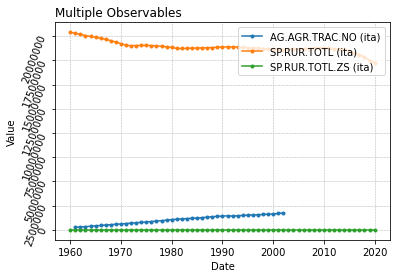

In [7]:
from src.opandas_wb.api.plots import *

ind_1 = 'AG.AGR.TRAC.NO'
ind_2 = 'SP.RUR.TOTL'
ind_3 = 'SP.RUR.TOTL.ZS'
country = 'ita'
indicators = [(ind_1, country), (ind_2, country), (ind_3, country)]
multi_indicator_plot(indicators).show()

# Grafico Media mobile

Il metodo 'media_mobile' permette di graficare la media mobile di un osservabile, come parametri di input richiede il nome dell'indicatore relativo all'osservabile, il paese dell'osservabile e il valore della finestra. Dopodiché calcola i punti per la media mobile, li inserisce in un array numpy e li grafica sempre tramite il metodo `plot()` di matplotlib.pyplot.
Sia $w$ la dimensione della finestra, la formula utilizzata per calcolare i punti della media mobile e':

$$ y_k = \frac{\sum_{k=i}^{i+w} x_k}{w} \forall i = 1,2,...,n-w$$

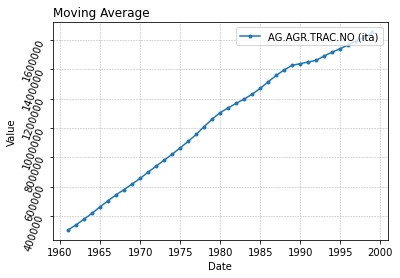

In [8]:
media_mobile(ind_1, 'ita', 3).show()

# Grafici delle covarianze

Il metodo `covarianza()` prende in input due tuple contenenti il nome dell'indicatore e del paese relativi all'osservabile. E' consigliabile scegliere due serie di osservabili appartenenti allo stesso paese, ma che riguardano indicatori diversi. I due set di valori vengono convertiti in pandas Series e tramite il metodo `cov()` vengono usati i punti delle due serie di osservabili per calcolare la covarianza.
Abbiamo pensato di rappresentare su un grafico scatter le due serie, per visualizzare graficamente se il risultato della covarianza ha senso, attraverso il metodo 'cmp_scatter_plot'. Infatti, nell'esempio che segue per le prime due coppie di indicatori, la covarianza è negativa e il grafico ha un andamento decrescente, mentre per la terza ha un andamento crescente e covarianza positiva. Se i punti fossero sparpagliati senza nessuna tendenza evidente, allora la covarianza sarebbe vicina a 0. Nell' ultimo caso, viene calcolata la covarianza della serie di osservabili con se stessa, ovvero la varianza e notiamo che la retta ha coefficiente angolare 1.

cov(AG.AGR.TRAC.NO,SP.RUR.TOTL)=-193974735025.69745


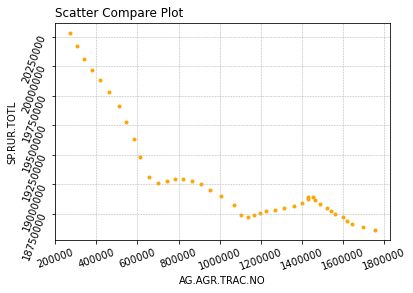

cov(AG.AGR.TRAC.NO,SP.RUR.TOTL.ZS)=-932980.7657119631


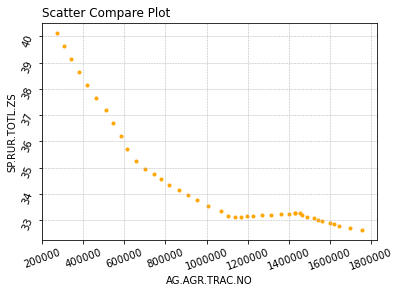

cov(SP.RUR.TOTL,SP.RUR.TOTL.ZS)=1423723.0456726772


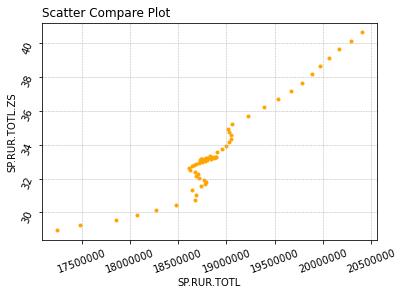

cov(AG.AGR.TRAC.NO,AG.AGR.TRAC.NO)=200933562392.78336


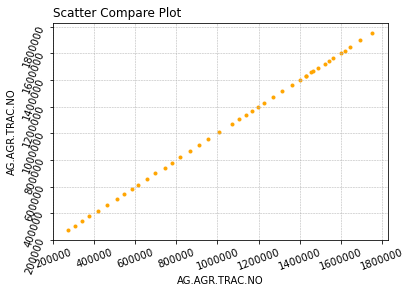

In [9]:
x_values = (ind_1, country)
y_values = (ind_2, country)
print("cov({},{})={}".format(ind_1, ind_2, covarianza(x_values, y_values)))
cmp_scatter_plot(x_values, y_values).show()

x_values = (ind_1, country)
y_values = (ind_3, country)
print("cov({},{})={}".format(ind_1, ind_3, covarianza(x_values, y_values)))
cmp_scatter_plot(x_values, y_values).show()

x_values = (ind_2, country)
y_values = (ind_3, country)
print("cov({},{})={}".format(ind_2, ind_3, covarianza(x_values, y_values)))
cmp_scatter_plot(x_values, y_values).show()

x_values = y_values = (ind_1, country)
print("cov({},{})={}".format(ind_1, ind_1, covarianza(x_values, y_values)))
cmp_scatter_plot(x_values, y_values).show()

# Grafici delle differenze prime

I metodi 'diff_prime' e 'diff_prime_perc' permettono di graficare le differenze prime e le differenze prime percentuali delle tre serie di osservabili scelte. Anche in questo caso i dati delle singole serie vengono convertiti in pandas series per poter poi utilizzare rispettivamente i metodi pandas 'diff' e 'pct_change' e calcolare quindi i valori finali. Dopo aver aggiunto la legenda, le tre serie sono state riunite in un unico grafico ritardando la chiamata al metodo plt.show().

La formula per calcolare le differenze prime, utilizzata dal metodo diff():

$$ y_i = x_i - x_{i-1}, \forall i = 2,...,n $$

mentre la formula per le differenze prime percentuali usata da pct_change():

$$ y_i = \frac{x_i - x_{i-1}}{x_{i-1}}, \forall i = 2,...,n $$

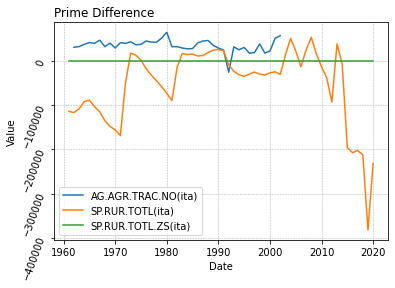

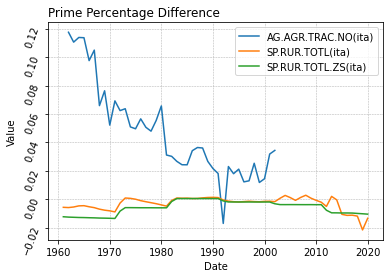

In [10]:
import matplotlib.pyplot as plt
l = ["{}({})".format(ind_1, country), "{}({})".format(ind_2, country), "{}({})".format(ind_3, country)]
diff_prime(ind_1, country)
diff_prime(ind_2, country)
diff_prime(ind_3, country)
plt.legend(l)
plt.show()
diff_prime_perc(ind_1, country)
diff_prime_perc(ind_2, country)
diff_prime_perc(ind_3, country)
plt.legend(l)
plt.show()

# Rette di regressione

Il metodo 'retta_reg' permette di calcolare e graficare la retta di regressione di una serie di osservabili. Prende come parametro di input il nome dell'indicatore ed il paese relativo all'osservabile. In questo caso le serie di valori vengono convertite in array numpy per poter utilizzare il metodo `mean()` per calcolare le medie campionarie dei valori degli osservabili, necessarie per il calcolo dei punti della retta di regressione.

La formula usata per calcolare i punti della retta di regressione è la seguente:
$$ b_0 = \bar{y}_n - \frac{\sum_{k=1}^n (x_k -\bar{x}_n)(y_k-\bar{y}_n)}{\sum_{k=1}^n (x_k -\bar{x}_n)^2}\cdot \bar{x}_n $$
$$
    b_1 = \frac{\sum_{k=1}^n (x_k -\bar{x}_n)(y_k-\bar{y}_n)}{\sum_{k=1}^n (x_k -\bar{x}_n)^2}
$$

$$ y_k = b_0 +b_1\cdot x_k, \forall k = 1,...,n $$

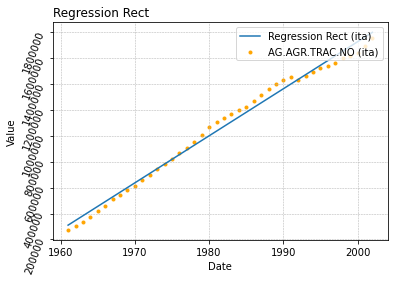

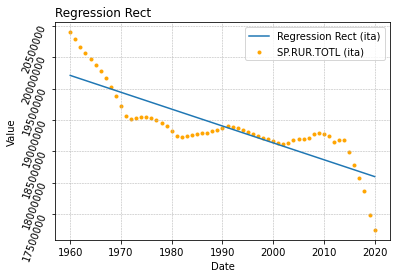

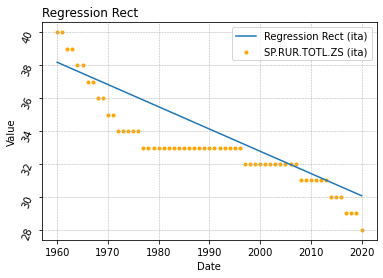

In [11]:
retta_reg(ind_1, country).show()
retta_reg(ind_2, country).show()
retta_reg(ind_3, country).show()